<a href="https://colab.research.google.com/github/kimdonggyun/SLR/blob/main/SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sea Level Rise Analysis**

## **Installing necessary packages**

In [ ]:
# install package
%%capture
!pip install geopandas folium rasterio pykml shapely ipyleaflet fiona ipywidgets ipympl

## **Import libraries**

In [ ]:
# import libraries required
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import re
from osgeo import gdal
from pykml import parser
import geopandas as gpd
import folium
import fiona
from shapely.geometry import Polygon
from ipyleaflet import Map, GeoJSON, DrawControl
from ipywidgets import interact, interactive, fixed, interact_manual, Button, Output
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import imageio
import os
import glob

## **Define functions**

In [ ]:
# Build Functions and Set Variables

# 1. calculate height development of trees
# apply gompertz growth model for the yearly height development
def gompertz_height(t, a, b, c):
    """
    Gompertz growth model.
    Args:
        t: Time points.
        a: Maximum height <- maximum height of the tree
        b: Growth rate parameter <- It changes the shape of the curve
        c: Shape parameter <- It changes the shape of the curve
    Returns:
        Predicted heights.
    """
    return a * np.exp(-b * np.exp(-c * t))


# 2. calculate magnitude of risk on mangrove survival rate with regard to sea level rise
# survival rate calculation with regard to the sea level and tree height
def survival_rate(sea_level, tree_height):
  """
  Args:
    sea_level: sea level in meters
    tree_height: tree height in meters
  Returns:
    survival rate as rate 0-1 (1 is highest survival rate (100%)) and 0 is lowest survival rate (0%)
  """
  r = (tree_height - sea_level) / tree_height
  if r <0.2:
    rate = 1
  elif r<0.3 and r>=0.2:
    rate = 0.8
  elif r<0.4 and r>=0.3:
    rate = 0.7
  elif r<0.6 and r>=0.4:
    rate = 0.6
  elif r<0.8 and r>=0.6:
    rate = 0.4
  elif r<1.0 and r>=0.8:
    rate = 0.2
  else:
    rate = 1
  return rate

# calculate average sea level anomaly
# annual sea level anomaluy based on https://sealevel.nasa.gov/data-analysis-tool
# not applied in the later step. Include it if precise survival rate is necessary
anomaly_SL = np.linspace(0, 0.21, 6) # unit meter

# calculate erosion rate
# not applied in the later step. Include it if precise survival rate is necessary
# this deginition should be modified
def simulate_erosion(df, erosion_factor=0.5):
    """
    Simulate soil erosion and sediment redistribution based on sea level rise.
    This function applies the Bruun rule to simulate erosion and sediment redistribution,
    however, does not exactly follow the Bruun rule.
    The basic concept of Brunn rule is applied (i.e., Eroded soil near the shorline is distributed on the active profile).
    It depends on the project area where mangroves are planted, but the mangrove planting area does not cover most of the active coastal profile,
    certain ratio of eroded soil will be re-distributed on the project area having certain depth.

    Parameters:
    df (pd.DataFrame): DataFrame containing longitude, latitude, and depth columns.
    erosion_factor (float): Factor determining the extent of erosion (default is 0.1).

    Returns:
    pd.DataFrame: DataFrame with updated depth information after erosion and sediment redistribution.

    Bruun rule
    R: shorline recession in meters
    S: Sea level rise
    L: horizontal length of the bottom affected by the sea level rise in meters
    h: depth of closure in meters
    B: dune height above sea level in meters
    Beta: average slope of the active profile

    R = (S*L)/(h+B) = S/tan(Beta)
    """
    # 1. Identify grids where depth is between 0 and -0.5 (erosion zone)
    erosion_zone = df[(df['depth'] < 0) & (df['depth'] > -0.5)].copy()

    # 2. Calculate eroded volume for each grid in the erosion zone
    # Since grid area is 1m², volume calculation simplifies to depth * erosion_factor
    erosion_zone['eroded_volume'] = erosion_factor * erosion_zone['depth'].abs()

    # 3. Sum the total eroded volume
    total_eroded_volume = erosion_zone['eroded_volume'].sum()

    # 4. Distribute 50% of the total eroded volume to grids where depth is < 0 (deeper grids)
    deep_grids = df[df['depth'] < 0].copy()
    if not deep_grids.empty:
        volume_per_grid = (total_eroded_volume * 0.5) / len(deep_grids)
        df.loc[df['depth'] < 0, 'depth'] += volume_per_grid

    # 5. Update the depths in the erosion zone (erode the soil in the shallower grids)
    df.loc[(df['depth'] < 0) & (df['depth'] > -0.5), 'depth'] -= erosion_zone['eroded_volume']

    # Return the updated DataFrame
    return df

In [ ]:
# Functions for plotting polygon (planting area) and selecting the shoreline on the interactive map

# Create a plot with polygon having vertices
def plot_polygon_with_vertices(geom):
    """
    Args
    geom: Polygon geometry

    Returns
    fig: Matplotlib figure
    ax: Matplotlib axis
    scatter: Scatter plot of vertices
    vertices: List of vertices (x, y)
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = geom.exterior.xy
    scatter = ax.scatter(x, y, color='yellow', picker=True)  # Emphasize vertices with red points
    ax.plot(x, y, color='black', linewidth=0.7)  # Plot the polygon
    ax.set_title("Click on vertices to select")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.ticklabel_format(useOffset=False)
    return fig, ax, scatter, list(zip(x, y))

# Create grid inside of the polygon (Project area)
def create_grid_in_polygon(polygon, cell_size=0.0001):
    """
    Create a grid of cells within a given polygon with a specified cell size.
    0.00001 degree equals to 1m. Except near the poles
    The size of the grid cell is determined by the cell_size parameter.
    https://www.dcceew.gov.au/themes/custom/awe/fullcam/Help-FullCAM2020/180_Latitude%20and%20Longitude.htm#:~:text=Length%20Approximations,-One%20degree%20of&text=One%20hundredth%20of%20a%20degree,degrees%20is%20about%20a%20metre).

    Args
    polygon: Polygon geometry
    cell_size: Size of the grid cell in degrees (default 0.0001 degree; 1m)

    Returns
    grid_gdf: GeoDataFrame containing the grid cells
    """
    # Get the bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate the grid cells (1x1 meter squares)
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    grid_cells = []

    for x in x_coords:
        for y in y_coords:
            cell = Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
            if polygon.intersects(cell):
                grid_cells.append(cell)

    # Create a GeoDataFrame for the grid cells
    grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

    return grid_gdf

# create function to handle clicks
def on_click(event, vertices, ax, fig, clicked_vertices):
    if event.inaxes is not None and event.xdata is not None and event.ydata is not None:
        # Calculate distances from clicked point to all vertices
        distances = [np.sqrt((vertex[0] - event.xdata)**2 + (vertex[1] - event.ydata)**2) for vertex in vertices]

        # Find the closest vertex
        min_distance_index = np.argmin(distances)
        closest_vertex = vertices[min_distance_index]

        if closest_vertex not in clicked_vertices:
            clicked_vertices.append(closest_vertex)
            ax.scatter(*closest_vertex, color='Green', marker='x')  # Show selected vertices
            fig.canvas.draw_idle()  # Redraw the plot
            print(f"Clicked vertex: {closest_vertex}")

# Interactive function to handle vertex selection with button
def interactive_plot_with_button(gdf_row, grid_gdf, number):
    geom = gdf_row.geometry.iloc[number]  # Extract the individual geometry
    fig, ax, scatter, vertices = plot_polygon_with_vertices(geom)

    grid_gdf.boundary.plot(ax=ax, color='silver', linewidth=0.2) # add grid cell in 1 meter resolution

    clicked_vertices = []
    # Connect the click event to the on_click function
    fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, vertices, ax, fig, clicked_vertices))

    # Create a button widget
    button = Button(description="Finish Selection")
    output = Output()

    def on_button_click(b):
        with output:
            print("Selection complete!")
            print("Selected vertices:", clicked_vertices)
        plt.close(fig)  # Close the plot window

    button.on_click(on_button_click)

    # Display the button and plot
    display(button, output)
    plt.show()

    return clicked_vertices

# Function to handle feature selection and modification
def handle_draw(self, action, geo_json):
    if action == 'created' or action == 'edited':
        coords = geo_json['geometry']['coordinates']
        print(f"Selected Line Coordinates: {coords}")

### **Present Tree Height Development Curve**

In [ ]:
# create plot of yearly height increase
a = 8  # Maximum height # <- adjust this parameter
b = 2.2  # Growth rate parameter # <- adjust this parameter
c = 0.08  # Shape parameter # <- adjust this parameter
t = np.arange(101)  # Time points from 0 to 100 years # <- adjust this parameter

height = gompertz_height(t, a, b, c)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(t, height, color='green')
plt.xlabel("Age (years)", size =12)
plt.ylabel("Height (meters)", size =12)
plt.title("Height Development", size =12)
plt.ylim(-0.5, 9)
plt.xlim(-3, 110)
plt.xticks(size =12)
plt.yticks(size =12)
plt.grid(True)

#save figure
plt.savefig('/content/drive/MyDrive/SLR/height_development.png') #<- reaplce the directory (/content/drive/MyDrive/SLR) and file name (height_development.png)
plt.close()

### **Load Sea Level Rise Projections and estimate the sea level of target region and year**
data source: https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool

In [ ]:
# Load Excel file
file_path = '/content/drive/MyDrive/SLR/ipcc_ar6_sea_level_projection_10_104.xlsx'  #<- reaplce the directory (/content/drive/MyDrive/SLR) and file name (ipcc_ar6_sea_level_projection_10_104.xlsx)
xls = pd.ExcelFile(file_path)

# Extract information from Total Rates Sheet
total_df = pd.read_excel(xls, sheet_name='Total Rates')

In [ ]:
# Filter for chosen model and percentile
ssp_model = total_df[
    (total_df['scenario'] == 'ssp245') & #<- choose a model to apply
    (total_df['quantile'] == 50) #<- choose a quantile to apply
]

# select the years of interest
year_of_interest = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2110, 2120] #<- choose years to apply
ssp_model_filtered = ssp_model[year_of_interest]
ssp_model_df = pd.DataFrame(columns=['year', 'sea_level'])
ssp_model_df['year'] = year_of_interest
ssp_model_df['sea_level'] = ssp_model_filtered.iloc[:, 0:].values[0]

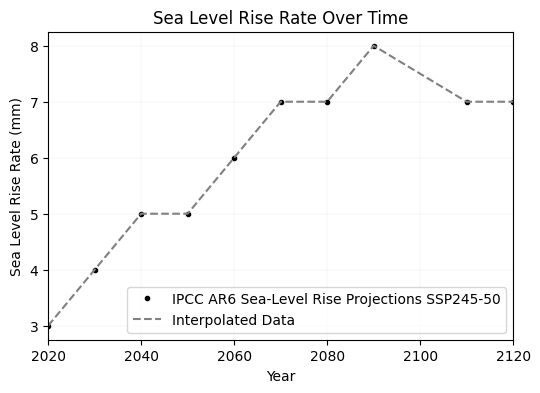

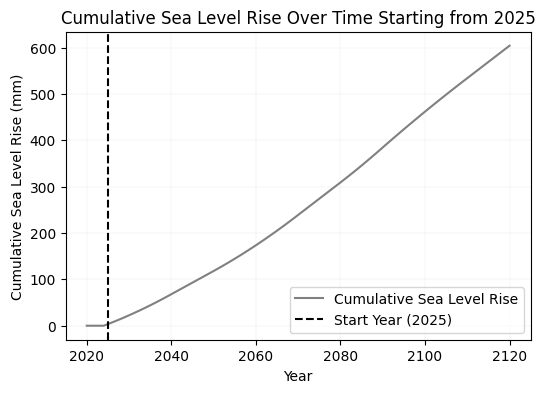

In [ ]:
# calculate the sea level rise scenario each year
years = np.arange(2020, 2121)

# Interpolate sea level rise values
SLR_interpolated_values = np.interp(years, ssp_model_df['year'], ssp_model_df['sea_level'])

# Create a DataFrame for interpolated Sea Level Rise Rate
SLR_interpolated_df = pd.DataFrame({
    'year': years,
    'sea_level_Interpolated': SLR_interpolated_values
})

# Create a DataFrame for interpolated cumulative Sea Level Rise
cumulative_sea_level_rise = np.zeros_like(SLR_interpolated_values)  # Initialize with zeros
start_year_index = np.where(years == 2025)[0][0]

# Calculate cumulative sea level rise
cumulative_sea_level_rise[start_year_index:] = np.cumsum(SLR_interpolated_values[start_year_index:])

# Create a DataFrame for the cumulative data
SLR_cumulative_interpolated_df = pd.DataFrame({
    'year': years,
    'sea_level_cumulative_interpolated': cumulative_sea_level_rise
})

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(ssp_model_df['year'], ssp_model_df['sea_level'], '.', label='IPCC AR6 Sea-Level Rise Projections SSP245-50', color="black")
plt.plot(SLR_interpolated_df['year'], SLR_interpolated_df['sea_level_Interpolated'], '--', label='Interpolated Data', color="gray")
plt.xlabel('Year')
plt.ylabel('Sea Level Rise Rate (mm)')
plt.xlim(2020, 2120)
plt.title('Sea Level Rise Rate Over Time')
plt.legend()
plt.grid(True, linewidth=0.1, color='silver')
plt.savefig('/content/drive/MyDrive/SLR/sea_level_rise_rate.png', dpi=300)  #<- reaplce the directory
plt.show()

# Plotting
plt.figure(figsize=(6,4))
plt.plot(SLR_cumulative_interpolated_df['year'], SLR_cumulative_interpolated_df['sea_level_cumulative_interpolated'], '-', label='Cumulative Sea Level Rise', color="gray")
plt.xlabel('Year')
plt.ylabel('Cumulative Sea Level Rise (mm)')
plt.title('Cumulative Sea Level Rise Over Time Starting from 2025')
plt.axvline(x=2025, color='black', linestyle='--', label='Start Year (2025)')
plt.legend()
plt.grid(True, linewidth=0.1, color='silver')
plt.savefig('/content/drive/MyDrive/SLR/sea_level_rise_cumulative.png', dpi=300)  #<- reaplce the directory
plt.show()

### **Load KML file and plot project area (polygon) in the map**




In [ ]:
# Load the KML file
# -------------------- (Repeat the process from here) ---------------------
fiona.drvsupport.supported_drivers['KML'] = 'rw'
kml_file_path = '/content/drive/MyDrive/SLR/100ha.kml'  #<- adjust the path to your KML file

# iterate through KML file
# create empty Geo Data Frame
gdf = gpd.GeoDataFrame()
# iterate over layers save the data on the Data Frame
for layer in fiona.listlayers(kml_file_path):
    # read layer into GeoDataFrame
    s = gpd.read_file(kml_file_path, driver='KML', layer=layer)
    s["Description"] = layer[0:]
    gdf = pd.concat([gdf, s], ignore_index=True)

# select certain data
province = "Kampot" #<- adjust name of region
gdf_sel = gdf.loc[gdf['Description']== province, :]
# Create a Folium map centered on the first geometry in the GeoDataFrame
center = [gdf_sel.geometry.centroid.y.mean(), gdf_sel.geometry.centroid.x.mean()]
m = Map(center=center, zoom=10)

# Add the polygons to the map
geo_json = GeoJSON(data=gdf_sel.__geo_interface__)
m.add_layer(geo_json)

# Create a DrawControl to enable polygon selection and editing
draw_control = DrawControl()

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# Display the map
m

<ipython-input-31-d0f1db978b8c>:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf_sel.geometry.centroid.y.mean(), gdf_sel.geometry.centroid.x.mean()]


Map(center=[10.55492340671421, 104.11077913227287], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### **Plot selected each project area (polygon) on a figure plot and select the vertices of shorline**

Button(description='Finish Selection', style=ButtonStyle())

Output()

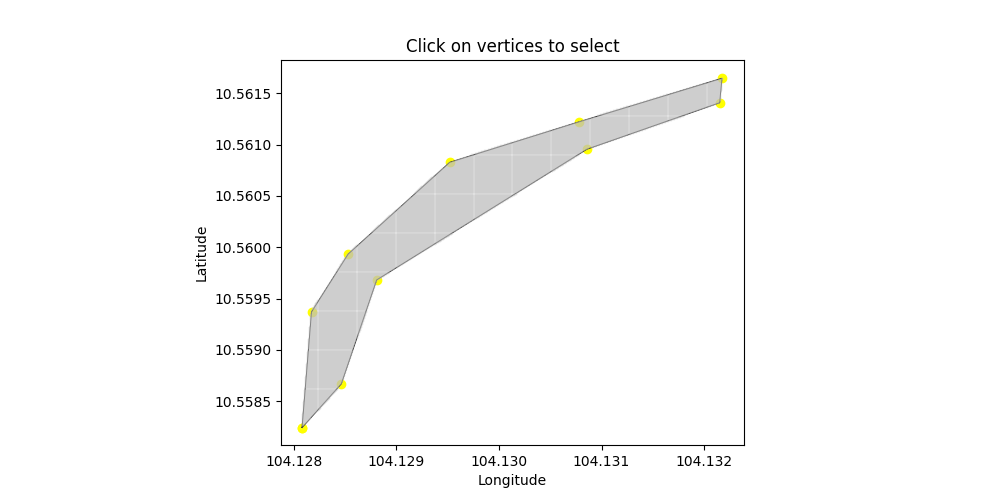

Selected vertices: []
Clicked vertex: (104.1280827660843, 10.55824449410154)
Clicked vertex: (104.1281748383617, 10.55937033728534)
Clicked vertex: (104.1285317952513, 10.55993361040274)
Clicked vertex: (104.1295218990959, 10.56082781141358)
Clicked vertex: (104.1307758824899, 10.56122040130345)
Clicked vertex: (104.1321733052724, 10.56164626098376)


In [ ]:
# Select vertices for the first polygon in the GeoDataFrame with button
# -------------------- (Repeat the process here) ---------------------
# activate widget interaction
%matplotlib widget
number = 11 # sequence of project area (polygon) #<- adjust the number to choose the polygon
polygon = gdf_sel.geometry.iloc[number]
area = gdf_sel.Name.iloc[number]
gdf_grid = create_grid_in_polygon(polygon, cell_size=0.00001) # 1m resolution #<- adjust the cell size (see the definition for the detail)
selected_vertices = interactive_plot_with_button(gdf_sel, gdf_grid, number)

print("Selected vertices:", selected_vertices)

### **Assign the depth for each cell and plot 3D polygon**

In [ ]:
# assign depth on each grid point
# Convert to LineString in the same CRS
line = LineString([Point(x, y) for x, y in selected_vertices])

# Calculate distances from each grid point to the line
gdf_grid['distance_to_line'] = gdf_grid.geometry.apply(lambda point: point.distance(line))

# Calculate depth based on distance (linearly decreasing depth as distance increases)
# -------------------- (change the inclination parameter here) ---------------------
slope = 2/100 #meter 2meter depth at 100m distance from the shorline without water #<- adjust this parameter based on the field observation
gdf_grid['depth'] = -(gdf_grid['distance_to_line']/0.00001) * slope

# apply soil erosion
#gdf_grid = simulate_erosion(gdf_grid, erosion_factor=0.2)

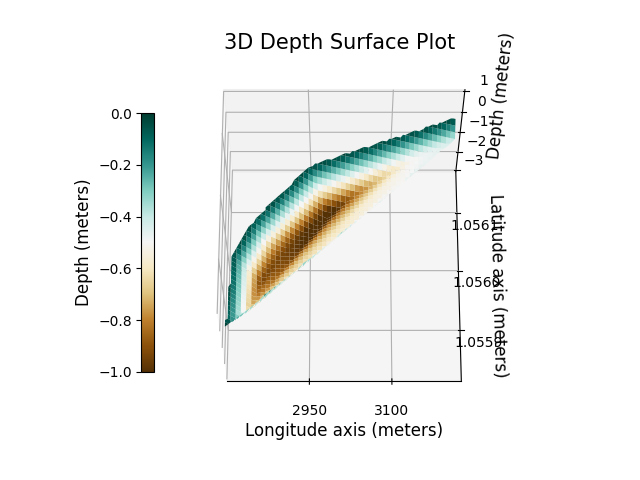

In [ ]:
# Plot 3D map
# Convert to DataFrame for plotting
df_grid = pd.DataFrame({
    'longitude': [p.centroid.x for p in gdf_grid.geometry],
    'latitude': [p.centroid.y for p in gdf_grid.geometry],
    'depth': gdf_grid['depth']
})

# Define grid boundaries
x = df_grid['longitude']
y = df_grid['latitude']
z = df_grid['depth']

# Create grid for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((x, y), z, (xi, yi), method='linear')

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf= ax.plot_surface(xi/0.00001, yi/0.00001, zi, cmap='BrBG', edgecolor='none')
surf.set_clim(-1, 0)

# Add color bar which maps values to colors
cbar = fig.colorbar(surf, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
cbar.set_label('Depth (meters)', fontsize=12)

# Labels and Title
ax.set_xlabel('Longitude axis (meters)', fontsize=12)
ax.set_ylabel('Latitude axis (meters)', fontsize=12)
ax.set_zlabel('Depth (meters)', fontsize=12)
ax.set_title('3D Depth Surface Plot', fontsize=15)
ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
ax.set_zlim(-3, 1)

# Control the number of axis-ticks
ax.zaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# Forcefully remove any stray scientific notation
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.view_init(elev=65, azim=-90) #set the view
plt.show()

# save figure
plt.savefig('/content/drive/MyDrive/SLR/%s_%s_%s_depth_surface.png' %(province, area, number), dpi=300) #<- replace the directory

### **Calculate Survival Rate based on the Sea Level Rise and Tree Height Development**

In [ ]:
# calulate the risk of sea level rise

#SLR_cumulative_interpolated_df
#df_grid
#height = gompertz_height(t, a, b, c)
#print(SLR_cumulative_interpolated_df)
#print(df_grid)
#survival_rate(sea_level, tree_height)
tree_height_df = pd.DataFrame(columns=['year', 'tree_height'])
tree_height_df['year'] = np.arange(2025, 2126)
tree_height_df['tree_height'] = height

tree_height_SLR = pd.merge(SLR_cumulative_interpolated_df, tree_height_df, on='year') # merge tree height and sea level rise dataframe by year

df_grid_scenario = df_grid.copy()

# Convert sea level from mm to meters for vectorized operations
tree_height_SLR['sea_level_meters'] = tree_height_SLR['sea_level_cumulative_interpolated'] / 1000

# Iterate over each year to calculate survival rates
for year in tree_height_SLR['year'].unique():
    # Filter the tree height and sea level for the specific year
    row_ts = tree_height_SLR[tree_height_SLR['year'] == year]
    sea_level = row_ts['sea_level_meters'].values[0]  # scalar value
    tree_height = row_ts['tree_height'].values[0]     # scalar value

    # Calculate survival rate for the entire grid at once (vectorized)
    df_grid_scenario['survival_rate_' + str(year)] = df_grid_scenario.apply(lambda row: survival_rate(sea_level - row['depth'], tree_height), axis=1)

#save df_grid_scenario as csv file
df_grid_scenario.to_csv('/content/drive/MyDrive/SLR/%s_%s_%s_df_grid_scenario.csv' %(province, area, number), index=False)
# -------------------- (Repeat the process by here to have dataframe) ---------------------

<ipython-input-67-7d6eb0607fe7>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 7))


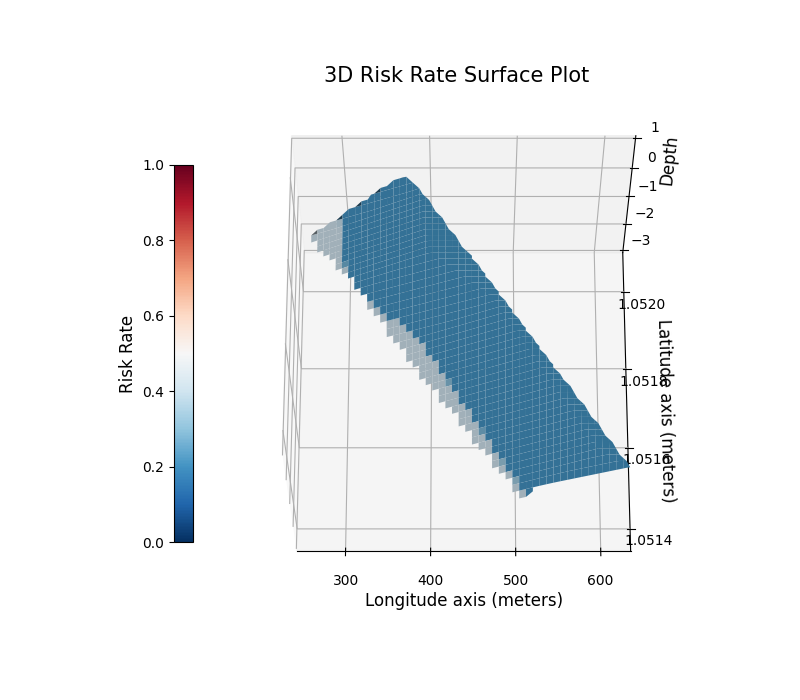

In [ ]:
# plot in 3d. Longitude as x value, latitude as y value, depth as z value and survival rate as color bar
# Create a 3D plot, Use grid boundaries, grid interpolation longitude and latitude data from above codes (x, y) (xi, yi)
z_risk = df_grid_scenario['survival_rate_2119']
zi_risk = griddata((x, y), z_risk, (xi, yi), method='linear')

# Plotting
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting
surf_risk = ax.plot_surface(xi / 0.00001, yi / 0.00001, zi, facecolors=cm.RdBu_r(zi_risk), edgecolor='none')
surf_risk.set_clim(0, 1)

# Create a ScalarMappable object for the color bar (no normalization needed)
mappable = cm.ScalarMappable(cmap='RdBu_r')
mappable.set_clim(0, 1)  # Set clim for the color range
mappable.set_array([])  # No need to set data here, just needed for color bar

# Adding a color bar with the fixed range of 0-1
cbar = fig.colorbar(mappable, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
cbar.set_label('Risk Rate', fontsize=12)  # Set label and its size

# Labels and Title
ax.set_xlabel('Longitude axis (meters)', fontsize=12)
ax.set_ylabel('Latitude axis (meters)', fontsize=12)
ax.set_zlabel('Depth', fontsize=12)
ax.set_title('3D Risk Rate Surface Plot', fontsize=15)
ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
ax.set_zlim(-3, 1)

# Control the number of axis-ticks
ax.zaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# Forcefully remove any stray scientific notation
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.view_init(elev=65, azim=-90) #set the view

# Show the plot
plt.show()

In [ ]:
# Ensure the output directory exists
output_dir = "/content/drive/MyDrive/SLR/animation_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List to store the file paths of generated frames
frames = []

# Iterate over each year from 2025 to 2120
for year in range(2025, 2121):
    # Extract the survival rate data for the current year
    z_risk = df_grid_scenario[f'survival_rate_{year}']
    zi_risk = griddata((x, y), z_risk, (xi, yi), method='linear')

    # Plotting
    surf_risk = ax.plot_surface(xi / 0.00001, yi / 0.00001, zi, facecolors=cm.RdBu_r(zi_risk), edgecolor='none')
    surf_risk.set_clim(0, 1)

    # Create a ScalarMappable object for the color bar (no normalization needed)
    mappable = cm.ScalarMappable(cmap='RdBu_r')
    mappable.set_clim(0, 1)  # Set clim for the color range
    mappable.set_array([])  # No need to set data here, just needed for color bar

    # Adding a color bar with the fixed range of 0-1
    cbar = fig.colorbar(mappable, ax=ax, aspect=20, shrink=0.7, location='left', pad=0.000001)
    cbar.set_label('Risk Rate', fontsize=12)  # Set label and its size

    # Labels and Title
    ax.set_xlabel('Longitude axis (meters)', fontsize=12)
    ax.set_ylabel('Latitude axis (meters)', fontsize=12)
    ax.set_zlabel('Depth', fontsize=12)
    ax.set_title(f'3D Risk Rate Surface Plot - Year {year}', fontsize=15)
    ax.set_xlim(min(x)/0.00001, max(x)/0.00001)
    ax.set_ylim(min(y)/0.00001, max(y)/0.00001)
    ax.set_zlim(-3, 1)

    # Control the number of axis-ticks
    ax.zaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # Forcefully remove any stray scientific notation
    ax.xaxis.get_offset_text().set_visible(False)
    ax.yaxis.get_offset_text().set_visible(False)

    ax.view_init(elev=65, azim=-90) #set the view

    # Save the frame
    frame_path = os.path.join(output_dir, f'frame_{year}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)

    # Clear the plot to avoid overlap in the next iteration
    plt.close(fig)

# Create a GIF from the saved frames
with imageio.get_writer(os.path.join("/content/drive/MyDrive/SLR", '%s_%s_%s_survival_rate_animation.gif' %(province, area, number) ), mode='I', duration=0.5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Optionally, remove the frame files
#for frame in frames:
#    os.remove(frame)

print("Animation saved as 'survival_rate_animation_soil.gif'")

<ipython-input-60-f6ae2c07ef13>:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


Animation saved as 'survival_rate_animation_soil.gif'


### **Combine risk analysis result of all project area**

In [ ]:
# Grab all files with _scenario.csv extension
files = glob.glob(os.path.join("/content/drive/MyDrive/SLR", '*_scenario.csv') )

# Combine all the files into a single DataFrame
df_list = [pd.read_csv(file) for file in files]
df_combined = pd.concat(df_list, ignore_index=True)

"""
# Filter columns having the form "survival_rate_(years)"
survival_rate_columns = [col for col in df_combined.columns if col.startswith('survival_rate_')]

# Calculate the frequency of numbers in each column
frequency_dict = {}
for col in survival_rate_columns:
    frequency_dict[col] = df_combined[col].value_counts().sort_index()

# Calculate the percentage of occurrence for each number in each column
percentage_dict = {}
for col in survival_rate_columns:
    percentage_dict[col] = df_combined[col].value_counts(normalize=True).sort_index() * 100

# Display the frequency and percentage results
for col in survival_rate_columns:
    print(f"\nColumn: {col}")
    print(f"Frequencies:\n{frequency_dict[col]}")
    print(f"Percentages:\n{percentage_dict[col]}")
"""

'\n# Filter columns having the form "survival_rate_(years)"\nsurvival_rate_columns = [col for col in df_combined.columns if col.startswith(\'survival_rate_\')]\n\n# Calculate the frequency of numbers in each column\nfrequency_dict = {}\nfor col in survival_rate_columns:\n    frequency_dict[col] = df_combined[col].value_counts().sort_index()\n\n# Calculate the percentage of occurrence for each number in each column\npercentage_dict = {}\nfor col in survival_rate_columns:\n    percentage_dict[col] = df_combined[col].value_counts(normalize=True).sort_index() * 100\n\n# Display the frequency and percentage results\nfor col in survival_rate_columns:\n    print(f"\nColumn: {col}")\n    print(f"Frequencies:\n{frequency_dict[col]}")\n    print(f"Percentages:\n{percentage_dict[col]}")\n'

In [ ]:
df_combined.describe()
# save comnbined dataframe
df_combined.to_csv('/content/drive/MyDrive/SLR/df_combined_Kampot_Kep.csv', index=False)

In [ ]:

# Specify the survival rates to count
rates_to_count = [1.0, 0.8, 0.6, 0.4, 0.2]

# Initialize a dictionary to hold the frequency count and percentages
frequency_percentage = {}

# Iterate through the years (columns) and count the frequencies
for year in range(2025, 2121):  # Adjust the range as necessary
    year_column = f'survival_rate_{year}'

    if year_column in df_combined.columns:
        # Count occurrences of specified rates
        count = df_combined[year_column].value_counts()

        # Calculate total counts for percentage calculation
        total_counts = count.sum()

        # Store frequency and percentage for specified rates
        frequency_percentage[year] = {}

        for rate in rates_to_count:
            rate_count = count.get(rate, 0)
            percentage = (rate_count / total_counts * 100) if total_counts > 0 else 0
            frequency_percentage[year][rate] = {
                'frequency': rate_count,
                'percentage': percentage
            }

# Convert to DataFrame for easier visualization
result_df = pd.DataFrame.from_dict(
    {year: {rate: freq['frequency'] for rate, freq in frequencies.items()}
     for year, frequencies in frequency_percentage.items()},
    orient='index'
)

percentage_df = pd.DataFrame.from_dict(
    {year: {rate: freq['percentage'] for rate, freq in frequencies.items()}
     for year, frequencies in frequency_percentage.items()},
    orient='index'
)

# Display the results
print("Frequency of risk rates by year:")
print(result_df)
print("\nPercentage of risk rates by year:")
print(percentage_df)

# save the data frame
result_df.to_csv('/content/drive/MyDrive/SLR/result_df_Kampot_Kep.csv', index=False)
percentage_df.to_csv('/content/drive/MyDrive/SLR/percentage_df_Kampot_Kep.csv', index=False)

Frequency of risk rates by year:
         1.0    0.8     0.6     0.4     0.2
2025  242426  57434  159429  206449  247464
2026  172610  56533  166518  231632  283534
2027  112039  52953  172123  252389  322485
2028   68242  41349  175194  268272  363079
2029   42056  27210  172790  281712  404358
...      ...    ...     ...     ...     ...
2116       0      0       0   95057  882484
2117       0      0       0   97137  880404
2118       0      0       0   99351  878190
2119       0      0       0  101628  875913
2120       0      0       0  103891  873650

[96 rows x 5 columns]

Percentage of risk rates by year:
            1.0       0.8        0.6        0.4        0.2
2025  24.799574  5.875355  16.309188  21.119216  25.314948
2026  17.657571  5.783185  17.034375  23.695374  29.004819
2027  11.461310  5.416959  17.607753  25.818764  32.989409
2028   6.980986  4.229899  17.921908  27.443555  37.142074
2029   4.302224  2.783515  17.675985  28.818433  41.364812
...         ...       ...  